# Lab #6: ANFIS for Option #1

In [96]:
df = pd.read_csv("anfis_variant1_data.csv")
df.head()


,IOC(0),IPC(0),KVVE(-7),M2(-7),IPC(+1)
0,194.935538,78.736345,473.803230,332.750702,54.243290
1,127.479018,124.653052,456.118962,271.936792,51.657539
2,177.933181,70.042578,402.224072,251.223605,45.041167
3,109.042026,86.984651,445.323028,248.314053,45.660932
4,185.730950,126.994302,403.381931,330.144884,57.520285


In [97]:
X = df[['IOC(0)', 'IPC(0)', 'KVVE(-7)', 'M2(-7)']].values
y = df['IPC(+1)'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [98]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [99]:
print(df.columns)

Index(['IOC(0)', 'IPC(0)', 'KVVE(-7)', 'M2(-7)', 'IPC(+1)'], dtype='object')


In [100]:
df = pd.read_csv("anfis_variant1_data.csv")


from sklearn.preprocessing import MinMaxScaler


X_raw = df.drop(columns=["IPC(+1)"]).values
y_raw = df["IPC(+1)"].values.reshape(-1, 1)


x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_scaled = x_scaler.fit_transform(X_raw)
y_scaled = y_scaler.fit_transform(y_raw).flatten()


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

with torch.no_grad():
    y_pred = model(X_test_tensor).numpy().flatten()
    y_pred_inv = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_test_inv = y_scaler.inverse_transform(y_test_tensor.numpy()).flatten()

In [101]:
class BellMembFunc(nn.Module):
    def __init__(self, a, b, c):
        super().__init__()
        self.a = nn.Parameter(torch.tensor(a, dtype=torch.float32))
        self.b = nn.Parameter(torch.tensor(b, dtype=torch.float32))
        self.c = nn.Parameter(torch.tensor(c, dtype=torch.float32))

    def forward(self, x):
        return 1 / (1 + torch.abs((x - self.c) / self.a) ** (2 * self.b))

In [102]:
class FuzzifyVariable(nn.Module):
    def __init__(self, mfs):
        super().__init__()
        self.mfs = nn.ModuleList(mfs)

    def forward(self, x):
        return torch.stack([mf(x) for mf in self.mfs], dim=1)

In [103]:
class FuzzifyLayer(nn.Module):
    def __init__(self, mfdefs, varnames):
        super().__init__()
        self.vars = nn.ModuleDict({
            name: FuzzifyVariable(mfs) for name, mfs in zip(varnames, mfdefs)
        })

    def forward(self, x):
        outputs = []
        for i, key in enumerate(self.vars.keys()):
            outputs.append(self.vars[key](x[:, i:i+1]))
        return torch.cat(outputs, dim=1)

In [104]:
class AntecedentLayer(nn.Module):
    def __init__(self, mfdefs):
        super().__init__()
        self.mfdefs = mfdefs

    def forward(self, x):
        batch_size = x.size(0)

        activations = []
        for i, mfs in enumerate(self.mfdefs):
            mf_vals = [mf(x[:, i:i+1]) for mf in mfs]
            acts = torch.cat(mf_vals, dim=1)
            activations.append(acts)



        result = activations[0]  # (batch, m1)

        for i in range(1, len(activations)):
            a = result.unsqueeze(2)                  # (batch, m1*m2*..., 1)
            b = activations[i].unsqueeze(1)          # (batch, 1, mi)
            result = (a * b).reshape(batch_size, -1) # (batch, m1*m2*...*mi)

        return result  # (batch, num_rules)

In [105]:
class PlainConsequentLayer(nn.Module):
    def __init__(self, in_features, num_rules, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features * num_rules, out_features)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, -1)  # (batch_size, num_rules * in_features)
        return self.linear(x)

In [106]:
from collections import OrderedDict

class AnfisNet(nn.Module):
    def __init__(self, description, invardefs, outvarnames):
        super().__init__()
        self.description = description
        self.outvarnames = outvarnames

        varnames = [v for v, _ in invardefs]
        mfdefs = [mfs for _, mfs in invardefs]

        self.num_in = len(invardefs)
        self.num_rules = np.prod([len(mfs) for mfs in mfdefs])
        self.num_out = len(outvarnames)

        self.layer = nn.ModuleDict(OrderedDict([
            ("fuzzify", FuzzifyLayer(mfdefs, varnames)),
            ("rules", AntecedentLayer(mfdefs)),
            ("consequent", PlainConsequentLayer(self.num_in, self.num_rules, self.num_out))
        ]))

    def forward(self, x):
        mu = self.layer["rules"](x)           # (batch_size, num_rules)
        mu_exp = mu.unsqueeze(-1)             # (batch_size, num_rules, 1)
        x_exp = x.unsqueeze(1)                # (batch_size, 1, num_inputs)
        weighted_x = mu_exp * x_exp           # (batch_size, num_rules, num_inputs)
        output = self.layer["consequent"](weighted_x)  # (batch_size, num_outputs)
        return output

In [107]:
def train_anfis_model(n_rules):

    n_mfs_per_input = 3


    input_mfs = []
    for _ in range(X.shape[1]):
        input_mfs.append([
            BellMembFunc(a=1.0, b=1.0, c=np.random.uniform(0.2, 0.8))
            for _ in range(n_mfs_per_input)
        ])


    invardefs = [(f'x{i}', input_mfs[i]) for i in range(X.shape[1])]
    outvarnames = ['y']
    description = f"ANFIS with {n_mfs_per_input}^{X.shape[1]} = {n_mfs_per_input ** X.shape[1]} rules"


    model = AnfisNet(description=description, invardefs=invardefs, outvarnames=outvarnames)

    optimizer = optim.Adam(model.parameters(), lr=0.05, betas=(0.1, 0.05))
    criterion = nn.MSELoss()
    n_epochs = 300
    loss_history = []

    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train_tensor)
        loss = criterion(y_pred, y_train_tensor)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

    return model, loss_history

In [108]:
results = {}

for n_rules in [10, 20, 40]:
    print(f"\nTraining a model with {n_rules} by the rules...")
    model, loss_history = train_anfis_model(n_rules)

    with torch.no_grad():
        y_pred = model(X_test_tensor).numpy().flatten()
        mse = mean_squared_error(y_test, y_pred)

    results[n_rules] = {
        "model": model,
        "loss": loss_history,
        "mse": mse
    }

    print(f"Number of rules: {n_rules}, MSE: {mse:.4f}")


Training a model with 10 by the rules...
Number of rules: 10, MSE: 0.0144

Training a model with 20 by the rules...
Number of rules: 20, MSE: 0.0215

Training a model with 40 by the rules...
Number of rules: 40, MSE: 0.0214


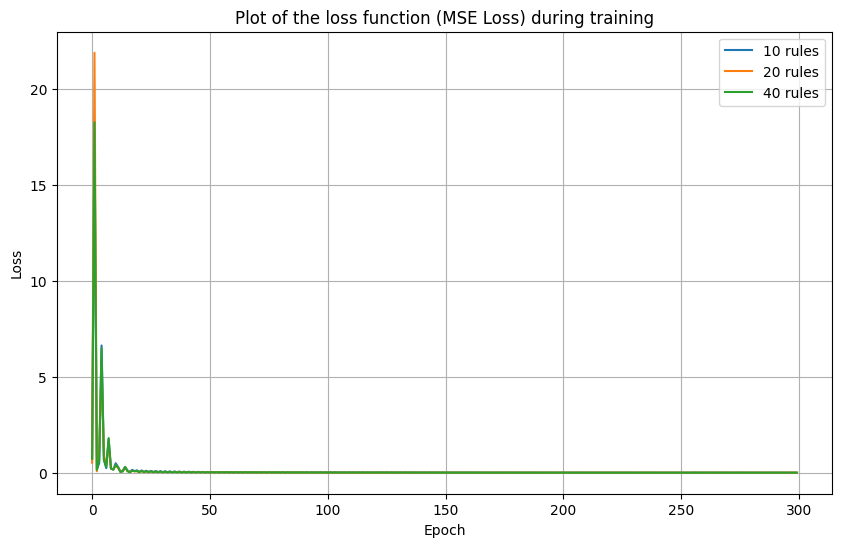

In [109]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for n_rules, data in results.items():
    plt.plot(data["loss"], label=f"{n_rules} rules")

plt.title("Plot of the loss function (MSE Loss) during training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [110]:
best_n = min(results, key=lambda r: results[r]["mse"])
best_model = results[best_n]["model"]

print(f"\nBest model: {best_n} rules, MSE = {results[best_n]['mse']:.4f}")


Best model: 10 rules, MSE = 0.0144


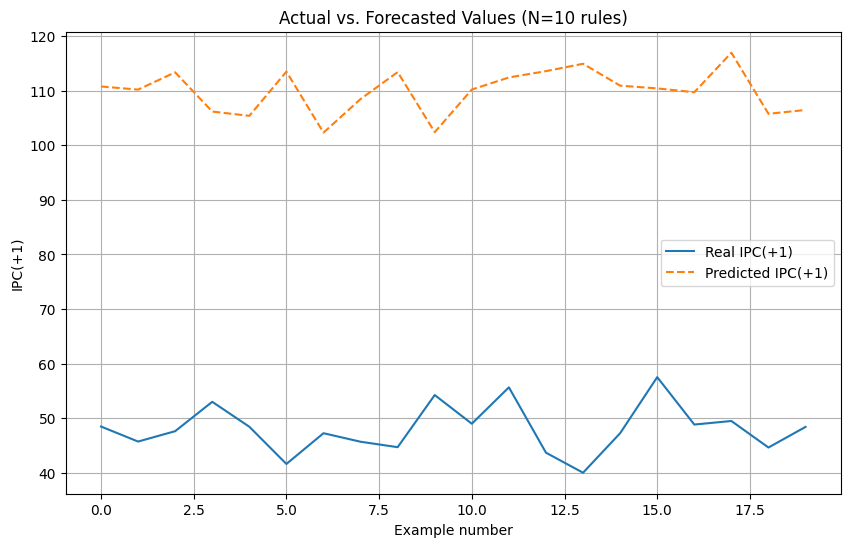

In [111]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label="Real IPC(+1)")
plt.plot(y_pred_inv, label="Predicted IPC(+1)", linestyle="--")
plt.title(f"Actual vs. Forecasted Values (N={best_n} rules)")
plt.xlabel("Example number")
plt.ylabel("IPC(+1)")
plt.legend()
plt.grid(True)
plt.show()

In [112]:
import pandas as pd

df_results = pd.DataFrame({
    "Actual IPC(+1)": y_test_inv,
    "Predicted IPC(+1)": y_pred_inv
})
df_results.to_excel("anfis_predictions.xlsx", index=False)

In [113]:
from sklearn.metrics import r2_score, mean_absolute_error

print("R2 score:", r2_score(y_test_inv, y_pred_inv))
print("MAE:", mean_absolute_error(y_test_inv, y_pred_inv))

R2 score: -205.1588592529297
MAE: 61.79480743408203
